# Workflow: Predict number of 911 calls in each US block group.


**Background**: The 911 has been designated as the "<font color=green>Universal Emergency Number</font>" for citizens throughout the United States to request emergency assistance In 1968, 911 became the national emergency number for the United States The calls are placed by a Voice over Internet Protocol (”VoIP”) End-User to Carrier’s Internet Protocol (”IP”) services

**Importance**:

- A good understanding of expected 911 calls might help with resource allocation for 911 call centers
- Reduce the stress of the 911 operators, who suﬀer from signiﬁcant employee turnover
- Help strategy makers anticipate the occurrences of emergencies and enable them to effectively handle the emergency by appropriate allocation of resources

**Technology**:

1. Programming Languages: Python
2. Data Visualization: Seaborn

## Workflow using Python ArcGIS

### Connect to your ArcGIS online organization

In [5]:
from arcgis import *

In [6]:
gis = GIS("https://deldev.maps.arcgis.com", "demo_deldev", "P@ssword123")

Let's search **911 calls in Montgomery county** layer using the `search()` method from the content property of your gis object.you can pass a parameter **outside_org=True** to access the contents outside your organiation.

In [7]:
montgomery_calls = gis.content.search('title: "Montgomery 911 calls"', 'Feature layer', outside_org=True)

Import **dislay** module to see the list of searched items.

In [8]:
from IPython.display import display

<Item title:"Join Features to Montgomery 911 calls" type:Feature Layer Collection owner:arcgis_python>
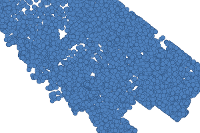

<Item title:"Montgomery 911 calls" type:Feature Layer Collection owner:demo_deldev>
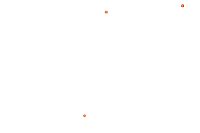

<Item title:"Aggregation of Montgomery 911 calls to USA Census BlockGroup Areas" type:Feature Layer Collection owner:demo_deldev>
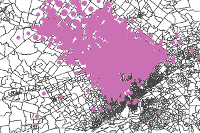

<Item title:"Hot Spots Montgomery 911 calls" type:Feature Layer Collection owner:demo_deldev>
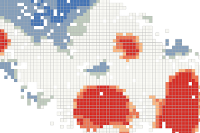

<Item title:"Find Outliers Montgomery 911 calls" type:Feature Layer Collection owner:demo_deldev>
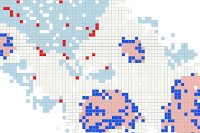

<Item title:"Find Locations in Montgomery 911 calls" type:Feature Layer Collection owner:demo_deldev>

<Item title:"Aggregation of Montgomery 911 calls to USA Census BlockGroups" type:Feature Layer Collection owner:demo_deldev>
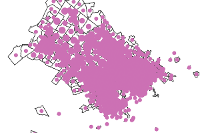

In [9]:
for item in montgomery_calls:
    display(item)

Get the **montgomery 911 calls** item.

In [10]:
mont_911_calls_item = montgomery_calls[1]

<Item title:"Montgomery 911 calls" type:Feature Layer Collection owner:demo_deldev>
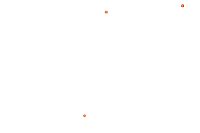

In [11]:
mont_911_calls_item

Since the item is a Feature Layer Collection, accessing the layers property will give us a list of FeatureLayer objects.

In [12]:
mont_911_calls = mont_911_calls_item.layers[0]

Since we want to predict number of 911 calss in block group for the year 2017.<br>
Our prediction must be based on 2016 data.<br>
Apply filter on the layer to keep only 2016 data.

In [13]:
mont_911_calls.filter = "timeStamp BETWEEN '2016-01-01 08:00:00' AND '2016-09-01 06:59:59'"

As we want to predcit number of 911calls in each block group of the montgomery county,<br> let's use the `search` method again to find US block group layer.

<Item title:"USA Block Groups" type:Feature Layer Collection owner:esri>
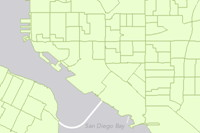

In [14]:
block_groups = gis.content.search('title: "USA Block Groups"', 'Feature layer', outside_org=True)[0]
block_groups

In [15]:
mont_block_groups = block_groups.layers[0]

Filter the block groups by "STCOFIPS = 42091" since FIPS code for montgomery county is 42091.

In [16]:
mont_block_groups.filter = "STCOFIPS = 42091"

In [17]:
mont_block_groups

<FeatureLayer url:"https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Block_Groups/FeatureServer/0">

### Use overlay tools to combine the 911 calls with US block groups
overlay_layers combines two or more layers into one single layer using either intersection, union  or erase method. 

In [18]:
from arcgis.features.manage_data import overlay_layers

In [19]:
intersect_blkgrp_with_calls = overlay_layers(mont_911_calls, mont_block_groups, tolerance=0, context={},
                           output_name="Combine 911 calls with blkgrp")

In [20]:
intersect_blkgrp_with_calls

<Item title:"Combine 911 calls with blkgrp" type:Feature Layer Collection owner:demo_deldev>

In [22]:
intersect_layer = intersect_blkgrp_with_calls.layers[0]

From the features module of you gis content import SpatialDataFrame tools which converts arcgis layer into spatial dataframe.

In [23]:
from arcgis.features import SpatialDataFrame

In [24]:
sdf = SpatialDataFrame.from_layer(intersect_blkgrp_with_calls.layers[0])

In [25]:
sdf.columns

Index(['AGE_10_14', 'AGE_15_19', 'AGE_20_24', 'AGE_25_34', 'AGE_35_44',
       'AGE_45_54', 'AGE_55_64', 'AGE_5_9', 'AGE_65_74', 'AGE_75_84',
       'AGE_85_UP', 'AGE_UNDER5', 'AMERI_ES', 'ASIAN', 'AVE_FAM_SZ',
       'AVE_HH_SZ', 'BLACK', 'BLKGRP', 'CNTY_FIPS', 'FAMILIES', 'FEMALES',
       'FHH_CHILD', 'FIPS', 'HAWN_PI', 'HISPANIC', 'HOUSEHOLDS', 'HSEHLD_1_F',
       'HSEHLD_1_M', 'HSE_UNITS', 'Join_Count', 'MALES', 'MARHH_CHD',
       'MARHH_NO_C', 'MED_AGE', 'MED_AGE_F', 'MED_AGE_M', 'MHH_CHILD',
       'MULT_RACE', 'OBJECTID_1', 'OTHER', 'OWNER_OCC', 'ObjectID',
       'POP10_SQMI', 'POP12_SQMI', 'POP2010', 'POP2012', 'RENTER_OCC', 'SQMI',
       'STATE_FIPS', 'STCOFIPS', 'TARGET_FID', 'TRACT', 'VACANT', 'WHITE',
       'addr', 'desc_', 'e', 'lat', 'lng', 'timeStamp', 'title', 'twp', 'zip',
       'SHAPE'],
      dtype='object')

Now we want to parse timestamp to get more information from it.<br>
We will extend the dataset with more time related values.

In [27]:
import pandas as pd
sdf['datetime'] = pd.to_datetime(sdf['timeStamp'], unit='ms')
sdf['month'] = sdf['datetime'].dt.month
sdf['day'] = sdf['datetime'].dt.day
sdf['dayofweek'] = sdf['datetime'].dt.dayofweek
sdf['week'] = sdf['datetime'].dt.week

We want to group our dataframe by county FIPS and tract.<br>
Framing a new column with combined code for county FIPS code and tract ID.

In [28]:
sdf['cntytract'] = sdf['STCOFIPS'] + sdf.TRACT

In [29]:
sdf['cntytract'].head()

0    42091203403
1    42091205801
2    42091201004
3    42091200306
4    42091203902
Name: cntytract, dtype: object

Montgomery County, locally also referred to as Montco, is a county located in the Commonwealth of Pennsylvania. As of the 2010 census, the population was 799,874, making it the third-most populous county in Pennsylvania, after Philadelphia and Allegheny Counties, and the 71st most populous in the United States.<br>
So let's take pop2012 as one of the significant predictor for our analysis.

In [30]:
final_columns = ["dayofweek", "week", "month", "day", "cntytract", "POP2012", "HOUSEHOLDS",
                 "FAMILIES", "MED_AGE"]

In [31]:
df =  sdf[final_columns]

In [32]:
groupby_list =   ["dayofweek", "week", "month", "day", "cntytract", "POP2012", "HOUSEHOLDS",
                 "FAMILIES", "MED_AGE"]

In [33]:
sdf_grouped = df.groupby(groupby_list).size().reset_index(name='count')

In [34]:
corr_matrix = sdf_grouped.corr()
corr_matrix['count'].sort_values()

week         -0.015564
dayofweek    -0.012391
month        -0.009381
day           0.006395
MED_AGE       0.047343
FAMILIES      0.111348
POP2012       0.121887
HOUSEHOLDS    0.138449
count         1.000000
Name: count, dtype: float64

911 calls have more correlation with number of households and populaation in each block group.  

In [35]:
y = sdf_grouped['count']

In [36]:
sdf_grouped.drop('count', inplace=True, axis=1)

Use sklearn library to split the dataframe into train and  test sets usin the **train_test split**.

In [37]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(sdf_grouped, y, random_state=0)

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

model = DecisionTreeRegressor(max_leaf_nodes=500)
model.fit(train_X, train_y)
predicted = model.predict(test_X)
r2_score(test_y, predicted)

0.11444650121487066

In [39]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=200, min_samples_leaf=6, max_features=0.6, n_jobs=-1)
forest = forest_reg.fit(train_X, train_y)
Predicted = forest.predict(test_X)
r2_score(test_y, Predicted)

0.2575687763457739

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(sdf_grouped,y,test_size = validation_size,random_state = seed)
model = GradientBoostingRegressor(n_estimators=200, 
                                  learning_rate=0.1, max_depth=5, random_state=0, loss='ls', warm_start =  True)
model.fit(X_train,Y_train)
r2_score(Y_test, model.predict(X_test))

0.2632751482579958

oops! The model has poor predictions.  

Let's analyze our dataframe to understand what all factors could affect the number of 911 calls.
Using the arcgis online organization you can navigate through the analysis variables availabe in the **enrich_layer** tools.
We assume that the factors affecting number of 911 calls could be related to the number of smart phone buyers. 

### Enriching the **mont_block_groups** with demographic variables
The enrich_layer tool gives you demographic and landascape data for the people, places, and businesses in a specific area, or within a selected travel time or distance from a location.

In [41]:
from arcgis.features.enrich_data import enrich_layer

In [42]:
blkgrp_smartphones_enrich = enrich_layer(mont_block_groups, 
                              analysis_variables=["PhonesYellowPages.MP27002A_B"], 
                              output_name='enrich__layer_with_1_variable')

In [43]:
blkgrp_smartphones_enrich

<Item title:"enrich__layer_with_1_variable" type:Feature Layer Collection owner:demo_deldev>

Again we use the **overlay_layers** tools from arcgis feature module.<br>
Repeat the process to predict the mkodel on the test set.<br>
Since we saw that month, week and dayofweek have negative as well as less correlations we are going to ignore those predictors
and ue enriched variables as our predictors for our analysis. 

In [44]:
interect_911call_enrichedBlkGrp = overlay_layers(mont_911_calls, blkgrp_smartphones_enrich, tolerance=0, context={},
                           output_name="interect_911call_enrichedBlkGrp")

In [45]:
en_sdf = SpatialDataFrame.from_layer(interect_911call_enrichedBlkGrp.layers[0])

In [46]:
en_sdf.shape

(91495, 70)

In [47]:
en_sdf.columns

Index(['AGE_10_14', 'AGE_15_19', 'AGE_20_24', 'AGE_25_34', 'AGE_35_44',
       'AGE_45_54', 'AGE_55_64', 'AGE_5_9', 'AGE_65_74', 'AGE_75_84',
       'AGE_85_UP', 'AGE_UNDER5', 'AMERI_ES', 'ASIAN', 'AVE_FAM_SZ',
       'AVE_HH_SZ', 'BLACK', 'BLKGRP', 'CNTY_FIPS', 'ENRICH_FID', 'FAMILIES',
       'FEMALES', 'FHH_CHILD', 'FIPS', 'HAWN_PI', 'HISPANIC', 'HOUSEHOLDS',
       'HSEHLD_1_F', 'HSEHLD_1_M', 'HSE_UNITS', 'HasData', 'ID', 'Join_Count',
       'MALES', 'MARHH_CHD', 'MARHH_NO_C', 'MED_AGE', 'MED_AGE_F', 'MED_AGE_M',
       'MHH_CHILD', 'MP27002a_B', 'MULT_RACE', 'OBJECTID_1', 'OTHER',
       'OWNER_OCC', 'ObjectID', 'POP10_SQMI', 'POP12_SQMI', 'POP2010',
       'POP2012', 'RENTER_OCC', 'SQMI', 'STATE_FIPS', 'STCOFIPS', 'TARGET_FID',
       'TRACT', 'VACANT', 'WHITE', 'addr', 'aggregationMethod', 'desc_', 'e',
       'lat', 'lng', 'sourceCountry', 'timeStamp', 'title', 'twp', 'zip',
       'SHAPE'],
      dtype='object')

In [48]:
en_sdf['datetime'] = pd.to_datetime(en_sdf['timeStamp'], unit='ms')
en_sdf['day'] = en_sdf['datetime'].dt.day

In [49]:
en_sdf['cntytract'] = en_sdf['STCOFIPS'] + en_sdf.TRACT

In [50]:
cols = ["day", "cntytract", "POP2012", "HOUSEHOLDS",
                 "FAMILIES", "MED_AGE", "MP27002a_B"]

In [51]:
en_df =  en_sdf[cols]

In [52]:
group_list =   ["day", "cntytract", "POP2012", "HOUSEHOLDS",
                 "FAMILIES", "MED_AGE", "MP27002a_B"]

In [53]:
en_sdf_grouped = en_df.groupby(group_list).size().reset_index(name='count')

In [54]:
corr_matrix = en_sdf_grouped.corr()
corr_matrix['count'].sort_values()

day          -0.010811
MED_AGE       0.077202
FAMILIES      0.224070
MP27002a_B    0.258259
POP2012       0.261039
HOUSEHOLDS    0.290274
count         1.000000
Name: count, dtype: float64

In [55]:
en_y = en_sdf_grouped['count']

In [56]:
en_sdf_grouped.drop('count', inplace=True, axis=1)

In [57]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(en_sdf_grouped, en_y, random_state=0)

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

model = DecisionTreeRegressor(max_leaf_nodes=500)
model.fit(x_train, y_train)
predicted = model.predict(x_test)
r2_score(y_test, predicted)

0.6898870637738551

In [59]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=200, min_samples_leaf=6, max_features=0.6, n_jobs=-1, oob_score=True)
forest = forest_reg.fit(x_train, y_train)
Predicted = forest.predict(x_test)
r2_score(y_test, Predicted)

0.7519347455511063

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(en_sdf_grouped,en_y,test_size = validation_size,random_state = seed)
model = GradientBoostingRegressor(n_estimators=200, 
                                  learning_rate=0.1, max_depth=5, random_state=0, loss='ls', warm_start =  True)
model.fit(X_train,Y_train)
r2_score(Y_test, model.predict(X_test))


0.7539521971735129

Wow!! We have dramatically improved results now.
By observing the category column of our dataframe we figure out that there are three major categories of 911 calls mainly traffic, fire and emergency.Pondering upon these as our factors we will now enrich our dataframe with relative road density, day time population of workers, unemployed population, diversity index and             .

### Lets add more demographic variables using the enrich_layer tool.

In [62]:
blkgrp_enrich = enrich_layer(blkgrp_smartphones_enrich, 
                              analysis_variables=["DaytimePopulation.DPOPWRK_CY","industry.UNEMP_CY",
                                                  "KeyUSFacts.DIVINDX_CY","Infrastructure.ROADSUM"], 
                              output_name='enrich__layer_with_5more_variables')

In [63]:
intersect_of_enriched_blockgrp_calls = overlay_layers(mont_911_calls, blkgrp_enrich, tolerance=0, context={},
                           output_name="enriched")

In [64]:
edf = SpatialDataFrame.from_layer(intersect_of_enriched_blockgrp_calls.layers[0])

In [68]:
edf['category'],edf['category2'] = edf['title'].str.split(':',1).str

In [70]:
edf = edf.drop(['title','category2'],axis = 1)
cat_unique = pd.DataFrame(edf.category.unique())

In [71]:
# 0 = EMS (Emergency Medical Services)
#1 = FIRE
# 2 =  TRAFFIC
CATEGORIES = {'EMS':0,'Fire':1,'Traffic':2}
edf['category'].replace(CATEGORIES,inplace=True)
edf.head()

,AGE_10_14,AGE_15_19,AGE_20_24,AGE_25_34,AGE_35_44,AGE_45_54,AGE_55_64,AGE_5_9,AGE_65_74,AGE_75_84,...,e,lat,lng,sourceCountry,sourceCountry_1,timeStamp,twp,zip,SHAPE,category
0,20,23,29,118,86,116,95,20,66,16,...,1,40.123710,-75.382390,US,US,1451635557000,WEST NORRITON,19403,"{'x': -8391529.2918, 'y': 4883935.812799998, '...",0
1,10,14,61,302,87,51,24,12,16,8,...,1,40.085338,-75.396135,US,US,1451635776000,UPPER MERION,19406,"{'x': -8393059.3671, 'y': 4878351.154600002, '...",0
2,104,117,82,233,275,316,299,104,163,283,...,1,40.229961,-75.313855,US,US,1451636733000,UPPER GWYNEDD,19446,"{'x': -8383899.9438000005, 'y': 4899416.015000...",0
3,127,116,139,229,203,354,299,97,160,61,...,1,40.166612,-75.067830,US,US,1451636769000,UPPER MORELAND,19006,"{'x': -8356512.588300001, 'y': 4890183.4439999...",0
4,59,58,109,203,123,99,68,83,34,19,...,1,40.113372,-75.341397,US,US,1451636825000,NORRISTOWN,19401,"{'x': -8386965.905200001, 'y': 4882430.8924999...",0


In [72]:
edf['datetime'] = pd.to_datetime(edf['timeStamp'], unit='ms')

In [73]:
edf['day'] = edf['datetime'].dt.day

In [74]:
edf['cntytract'] = edf['STCOFIPS'] + edf.TRACT

In [77]:
cols = ["day", "cntytract", "POP2012", "HOUSEHOLDS",
                 "FAMILIES", "MED_AGE", "MP27002a_B", "DIVINDX_CY", "DPOPWRK_CY", "RoadSum", "UNEMP_CY"]

In [78]:
rdf =  edf[cols]

In [81]:
group_list =   ["day", "cntytract", "POP2012", "HOUSEHOLDS",
                 "FAMILIES", "MED_AGE", "MP27002a_B", "DIVINDX_CY", "DPOPWRK_CY", "RoadSum", "UNEMP_CY"]

In [82]:
edf_grouped = rdf.groupby(group_list).size().reset_index(name='count')

In [83]:
corr_matrix = edf_grouped.corr()
corr_matrix['count'].sort_values()

day          -0.010811
DIVINDX_CY    0.060770
MED_AGE       0.077202
UNEMP_CY      0.119524
FAMILIES      0.224070
MP27002a_B    0.258259
POP2012       0.261039
HOUSEHOLDS    0.290274
RoadSum       0.306760
DPOPWRK_CY    0.400352
count         1.000000
Name: count, dtype: float64

In [84]:
enriched_y = edf_grouped['count']

In [85]:
edf_grouped.drop('count', inplace=True, axis=1)

In [86]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(edf_grouped, enriched_y, random_state=0)

In [87]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

model = DecisionTreeRegressor(max_leaf_nodes=500)
model.fit(x_train, y_train)
predicted = model.predict(x_test)
r2_score(y_test, predicted)

0.6970121511890337

In [88]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=200, min_samples_leaf=6, max_features=0.6, n_jobs=-1, oob_score=True)
forest = forest_reg.fit(x_train, y_train)
Predicted = forest.predict(x_test)
r2_score(y_test, Predicted)

0.7525032292892136

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
validation_size = 0.20
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(edf_grouped,enriched_y,test_size = validation_size,random_state = seed)
model = GradientBoostingRegressor(n_estimators=200, 
                                  learning_rate=0.1, max_depth=5, random_state=0, loss='ls', warm_start =  True)
model.fit(X_train,Y_train)
r2_score(Y_test, model.predict(X_test))

0.7638603774109038